In [198]:
pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy as shc
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [200]:
#Read CSV file
#df = pd.read_csv("D:/Spring 2025/PDS/Project/Data/Shopping Mall Customer Segmentation Data .csv")
df = pd.read_csv("D:/Spring 2025/PDS/Project/Data/Mall_Customers.csv")
df

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual Income   200 non-null    int64 
 4   Spending Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


As you can see there are no null values to our particular dataset.

In [202]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


All three variables (Age, Income, Spending Score) show means and medians that align closely, implying approximately symmetric distributions without extreme skew.

There’s ample diversity in your customer base—across ages (young adults to seniors), income levels ($20 k–$200 k), and engagement scores (1–100).

In [203]:

# 1) Flag every row that has the same values in A,B,C,D as at least one other row
dup_mask = df.duplicated(subset=['Gender','Age','Annual Income','Spending Score'], keep=False)
df['is_dup'] = dup_mask

# Quick check: how many total rows are involved in duplicates?
print("Rows involved in duplicates:", dup_mask.sum())

# 2) Build a summary table: each unique combination and its count
dup_summary = (
    df[dup_mask]
    .groupby(['Gender','Age','Annual Income','Spending Score'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

# Show only those combinations occurring more than once
dup_summary = dup_summary[dup_summary['count'] > 1]
dup_summary


Rows involved in duplicates: 0


,Gender,Age,Annual Income,Spending Score,count


In [204]:
corr_matrix = df[['Age', 'Annual Income', 'Spending Score']].corr()
corr_matrix

,Age,Annual Income,Spending Score
Age,1.000000,-0.012398,-0.327227
Annual Income,-0.012398,1.000000,0.009903
Spending Score,-0.327227,0.009903,1.000000


We don't find any strong co-relation between the Parameters.

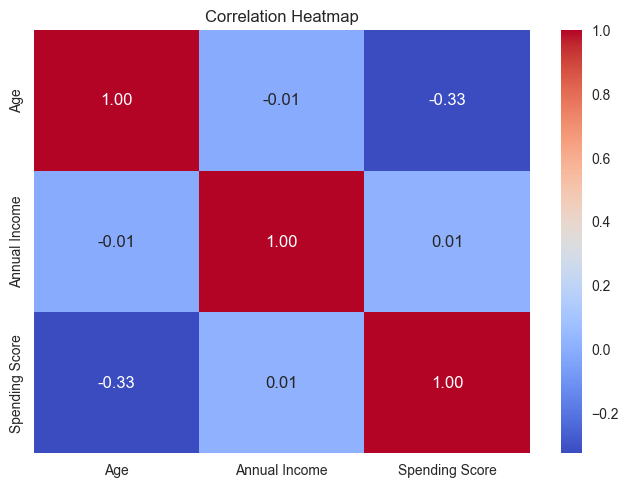

In [205]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # 'annot=True' shows correlation coefficients
plt.title('Correlation Heatmap')
plt.show()

In [206]:
#Data Visualization

Text(0.5, 1.0, 'Distribution of Age')

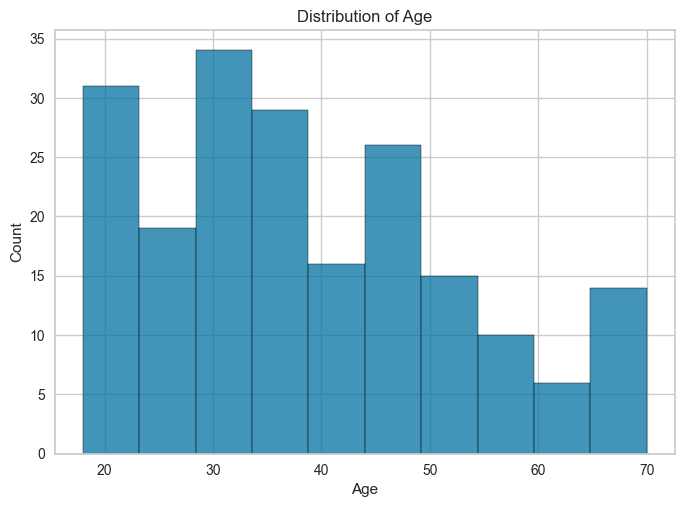

In [207]:

sns.histplot(df['Age'], bins=10)
plt.title('Distribution of Age')

Text(0.5, 1.0, 'Distribution of Annual income in k$')

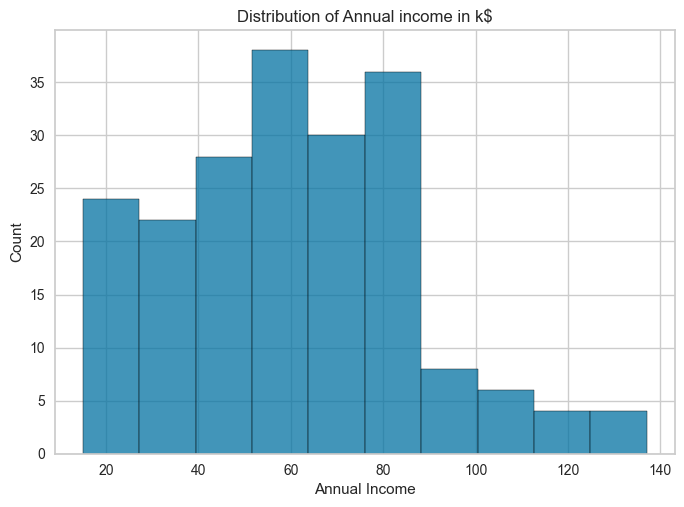

In [208]:

sns.histplot(df['Annual Income'], bins=10)
plt.title('Distribution of Annual income in k$')

Text(0.5, 1.0, 'Distribution of Spending Score')

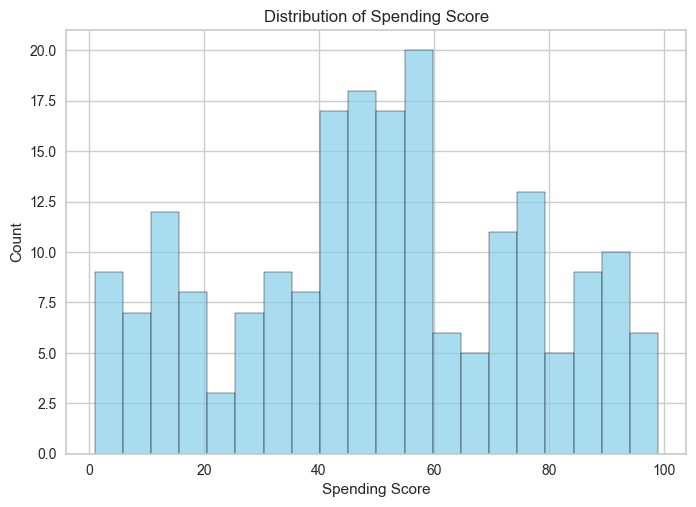

In [209]:
#sns.histplot(df['Spending Score'], bins=10)
sns.histplot(df['Spending Score'], 
             bins=20,       # Increased bins for more detail (adjust as needed      # Add a KDE curve
             color='skyblue', # Added color
             edgecolor='black', # Added edge color
             alpha=0.7)
plt.title('Distribution of Spending Score')

As you can see from the data visualisations, there are no increased concentration/majorities in each colum of the data. All the values in the dataset are equally distributed among all possible combinations.

In [210]:
gender_counts = df['Gender'].value_counts(normalize=True)
gender_counts

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

Also the Gender is almost equally distributed(50/50) and avoiding any kind of bais in the dataset. 

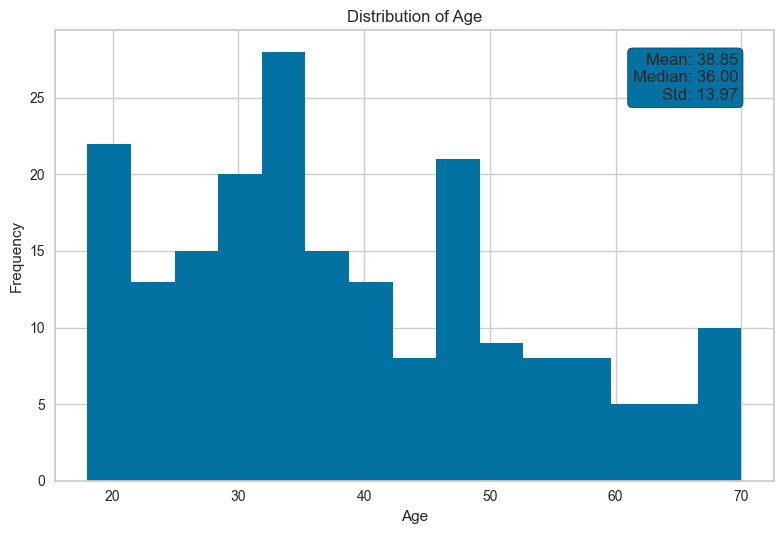

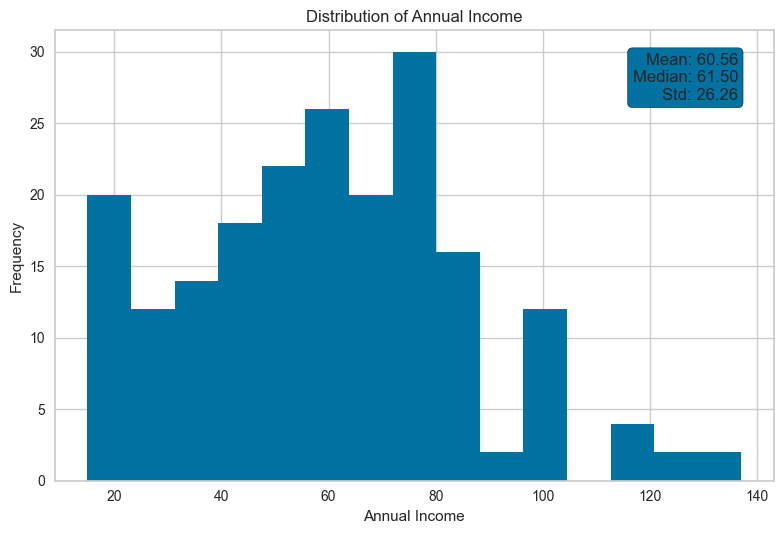

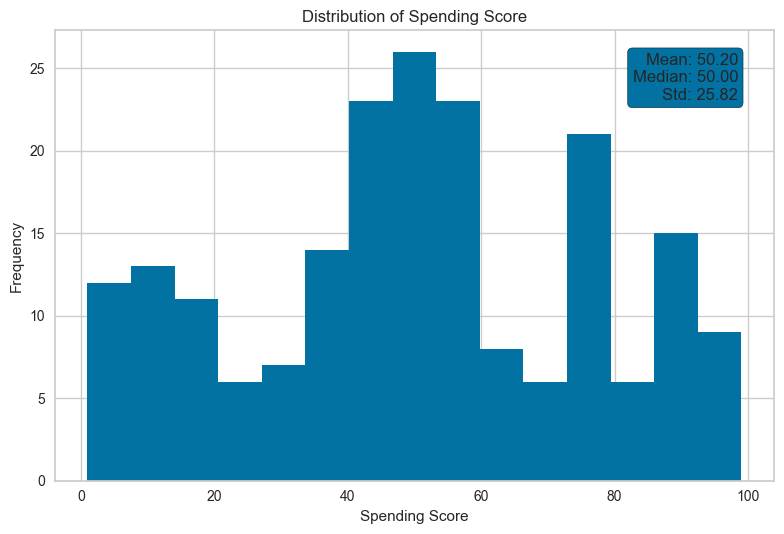

In [211]:
# 1. Randomly sample 200 observations
sample = df.sample(n=200, random_state=42)


numeric_cols = ['Age', 'Annual Income', 'Spending Score']

for col in numeric_cols:
    data = sample[col].dropna()
    mean = data.mean()
    median = data.median()
    std = data.std()
    
    plt.figure()  # new figure for each column
    plt.hist(data, bins=15)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Annotate metrics
    text = f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std:.2f}"
    plt.gca().text(0.95, 0.95, text,
                   transform=plt.gca().transAxes,
                   va='top', ha='right',
                   bbox=dict(boxstyle='round,pad=0.3', edgecolor='black'))
    
    plt.tight_layout()
    plt.show()

The above is the data visualisation of random picking 200 samples from the dataset to visualize the Numerical values in the Dataset. Along with the statistics on the top left. 

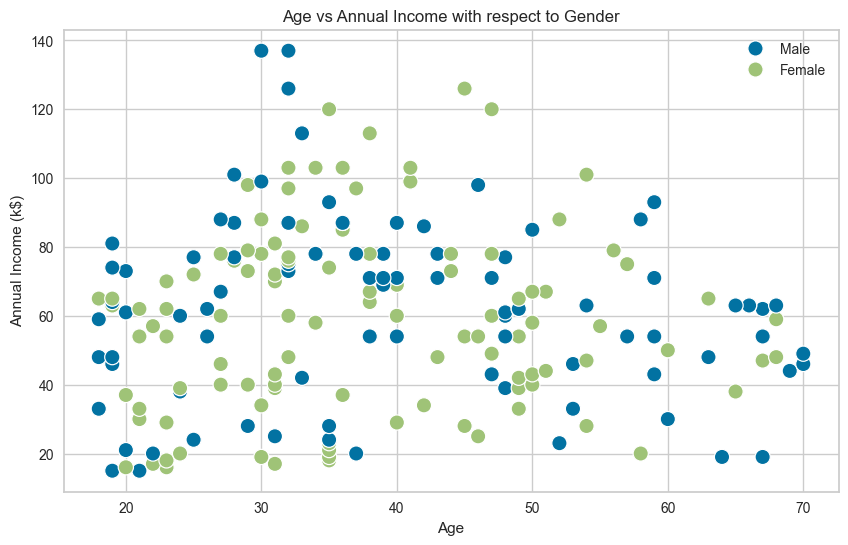

In [212]:
plt.figure(figsize = (10,6))
sns.scatterplot(x = 'Age', y = 'Annual Income', hue = 'Gender', data = df, s = 120)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)')
plt.title('Age vs Annual Income with respect to Gender')
plt.legend()
plt.show()

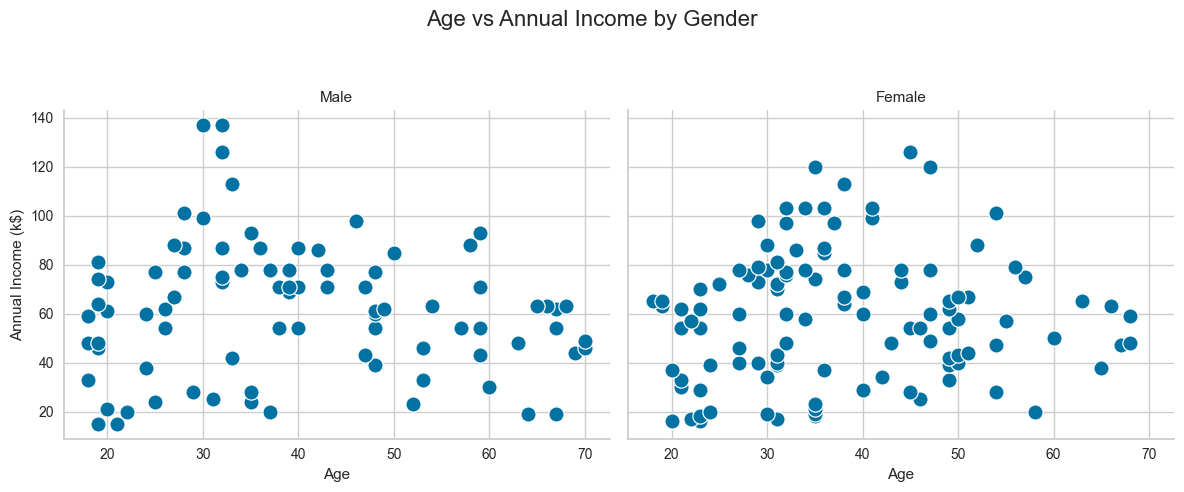

In [213]:
g = sns.FacetGrid(
    df, col='Gender',
    height=5, aspect=1.2,
    sharey=True
)
g.map_dataframe(
    sns.scatterplot,
    x='Age', y='Annual Income',
    s=120
)
g.set_axis_labels('Age', 'Annual Income (k$)')
g.set_titles('{col_name}')
g.fig.suptitle('Age vs Annual Income by Gender', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


#K-Means Clustering

In [214]:
X = df[['Annual Income', 'Spending Score']]


# convert to a numpy array so X[:,0], X[:,1] works
X.head() 


,Annual Income,Spending Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [215]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Elbow Method to determine the number of clusters to be formed:


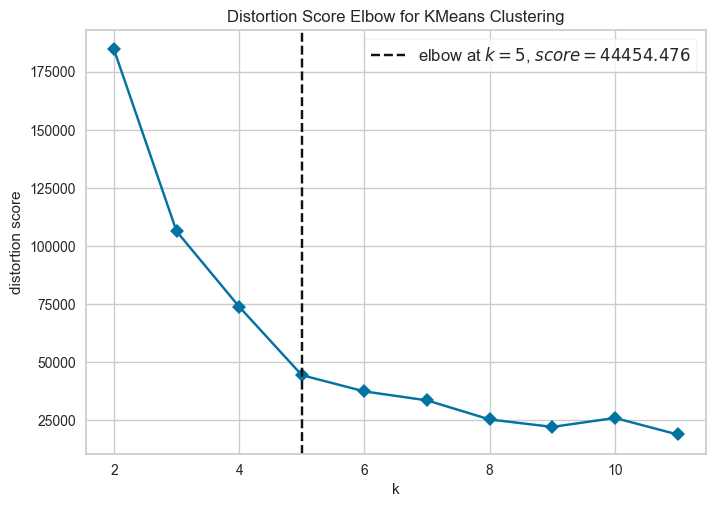

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [216]:
from yellowbrick.cluster import KElbowVisualizer

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=11, timings=False)
Elbow_M.fit(X)
Elbow_M.show()

From the elbow method ideally the K can be 4 or 5. Lets perform with bothe the values 

In [217]:
kmeans=KMeans(n_clusters=5, init = 'k-means++', random_state = 42)
clusters = kmeans.fit_predict(X_scaled)
df_clustered1 = df.copy()
df_clustered1['Cluster'] = clusters
df_clustered1.head()

,CustomerID,Gender,Age,Annual Income,Spending Score,is_dup,Cluster
0,1,Male,19,15,39,False,4
1,2,Male,21,15,81,False,2
2,3,Female,20,16,6,False,4
3,4,Female,23,16,77,False,2
4,5,Female,31,17,40,False,4


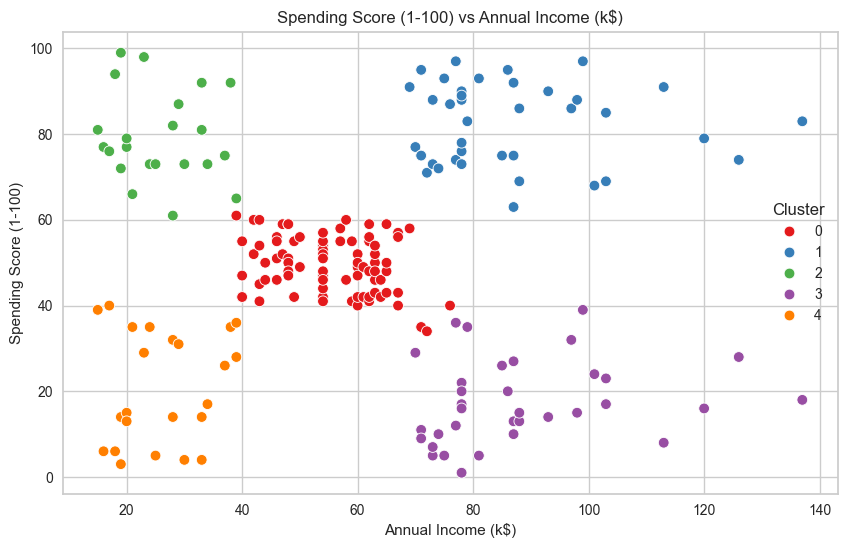

In [218]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Annual Income',y = 'Spending Score',hue="Cluster",
                 palette='Set1', data = df_clustered1, s = 60 )

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Spending Score (1-100) vs Annual Income (k$)')
plt.show()



Based on annual income and spending score, we identified five distinct clusters:

1. **Cluster 0**  
   - **Annual Income:** \$41 k – \$70 k  
   - **Spending Score:** 42 – 62  

2. **Cluster 1**  
   - **Annual Income:** \$72 k – \$137 k  
   - **Spending Score:** 1 – 42  

3. **Cluster 2**  
   - **Annual Income:** \$15 k – \$40 k  
   - **Spending Score:** 10 – 41  

4. **Cluster 3**  
   - **Annual Income:** \$15 k – \$40 k  
   - **Spending Score:** 62 – 99  

5. **Cluster 4**  
   - **Annual Income:** \$72 k – \$137 k  
   - **Spending Score:** 62 – 99  

---

- The **largest segment** is **Cluster 0**, containing the most customers, with an annual income between \$41 k and \$70 k and a mid‐range spending score (42–62).  
- The **smallest segment** is **Cluster 2**, with the fewest customers, characterized by lower incomes (\$15 k–\$40 k) and lower spending scores (10–41).


In [219]:
cluster_counts = df_clustered1['Cluster'].value_counts().sort_index()
print("Number of points in each cluster:")
print(cluster_counts)

Number of points in each cluster:
Cluster
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64


C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


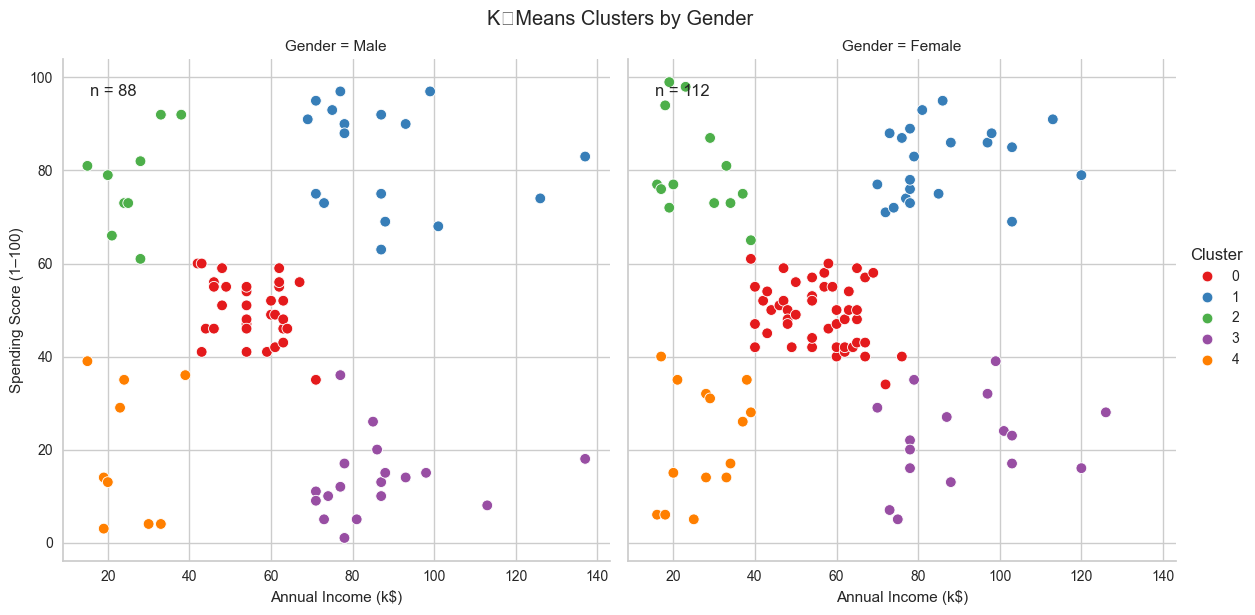

C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


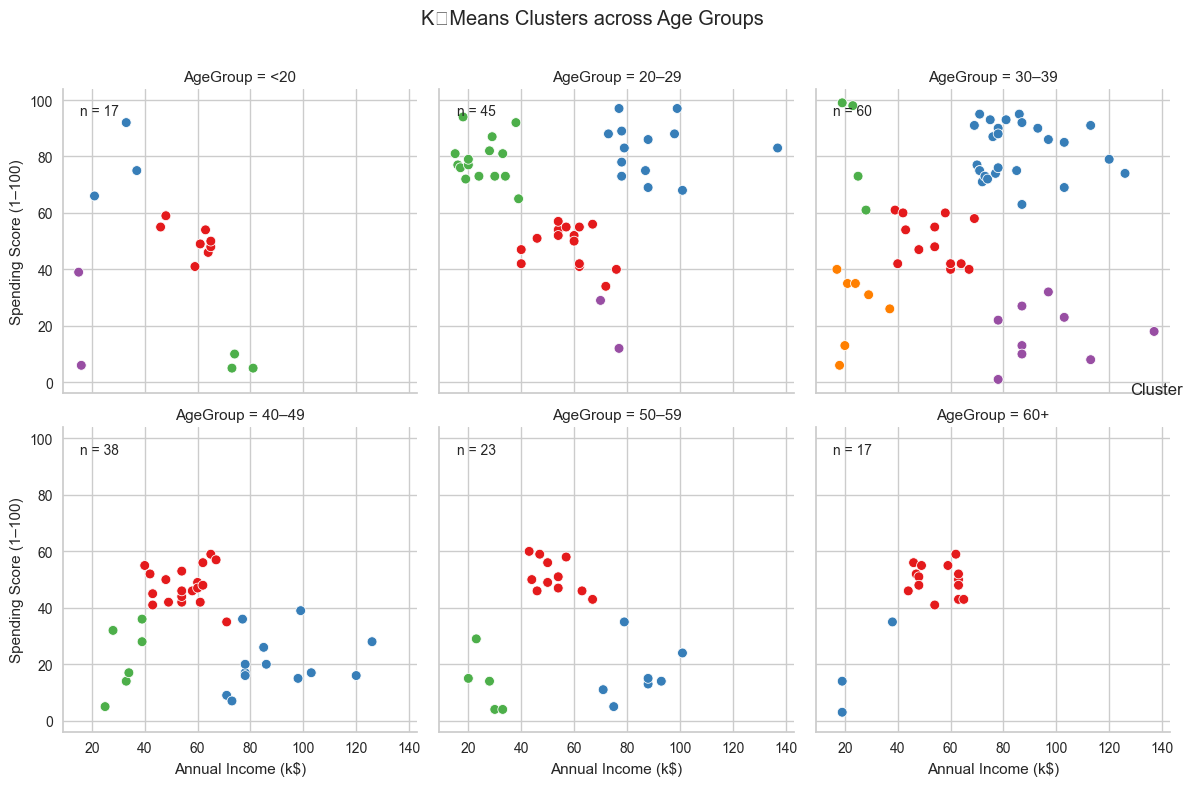

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Prepare AgeGroup bins if not already created ---
age_bins = [df_clustered1["Age"].min() - 1, 20, 30, 40, 50, 60, df_clustered1["Age"].max() + 1]
age_labels = ["<20", "20–29", "30–39", "40–49", "50–59", "60+"]
df_clustered1["AgeGroup"] = pd.cut(df_clustered1["Age"], bins=age_bins, labels=age_labels)

# 1) Plot clusters faceted by Gender with counts
g = sns.FacetGrid(df_clustered1, col="Gender", height=6, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot,
                x="Annual Income",
                y="Spending Score",
                hue="Cluster",
                palette="Set1",
                s=60)
g.add_legend(title="Cluster")
g.set_axis_labels("Annual Income (k$)", "Spending Score (1–100)")
g.fig.suptitle("K‑Means Clusters by Gender", y=1.02)

# Annotate each gender facet with number of points
for ax, gender in zip(g.axes.flat, g.col_names):
    count = df_clustered1[df_clustered1["Gender"] == gender].shape[0]
    ax.text(0.05, 0.95, f"n = {count}", transform=ax.transAxes,
            fontsize=12, verticalalignment='top')

plt.show()

# 2) Plot clusters faceted by AgeGroup with counts
g2 = sns.FacetGrid(df_clustered1, col="AgeGroup", col_wrap=3, height=4, sharex=True, sharey=True)
g2.map_dataframe(sns.scatterplot,
                 x="Annual Income",
                 y="Spending Score",
                 hue="Cluster",
                 palette="Set1",
                 s=50,
                 legend=False)
g2.set_axis_labels("Annual Income (k$)", "Spending Score (1–100)")
g2.fig.subplots_adjust(top=0.88)
g2.fig.suptitle("K‑Means Clusters across Age Groups")

# Annotate each age-group facet with number of points
for ax, age_group in zip(g2.axes.flat, g2.col_names):
    count = df_clustered1[df_clustered1["AgeGroup"] == age_group].shape[0]
    ax.text(0.05, 0.95, f"n = {count}", transform=ax.transAxes,
            fontsize=10, verticalalignment='top')

# Add a single legend outside the grid
handles, labels = g2.axes.flat[0].get_legend_handles_labels()
g2.fig.legend(handles, labels, title="Cluster", loc="center right")

plt.show()


In [220]:
silhouette_avg = silhouette_score(X,kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.553931997444648


Hierarchical Clustering

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [5.0, 5.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [90.0, 90.0, 112.5, 112.5],
  [75.0, 75.0, 101.25, 101.25],
  [60.0, 60.0, 88.125, 88.125],
  [17.5, 17.5, 74.0625, 74.0625],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [165.0, 165.0, 175.0, 175.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [170.0, 170.0, 192.5, 192.5],
  [142.5, 142.5, 181.25, 181.25],
  [45.78125, 45.78125, 161.875, 161.875],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [222.5, 222.5, 252.5, 252.5],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [282.5, 282.5, 312.5, 312.5],
  [237.5, 237.5, 297.5, 297.5],
  [335.0, 33

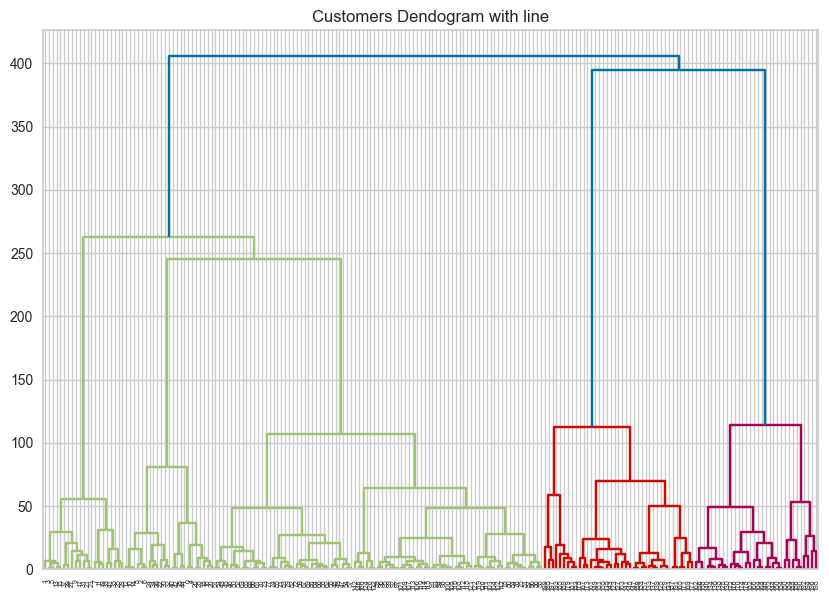

In [224]:

import scipy.cluster.hierarchy as shc

selected_data = df.iloc[:, 3:5]

plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(selected_data,
            method='ward',
            metric="euclidean")
shc.dendrogram(clusters)
# Add a reference line for potential cluster threshold (y=125)
#plt.axhline(y = 125, color = 'r', linestyle = '-')

Text(0.5, 1.0, 'Labeled Customer Data')

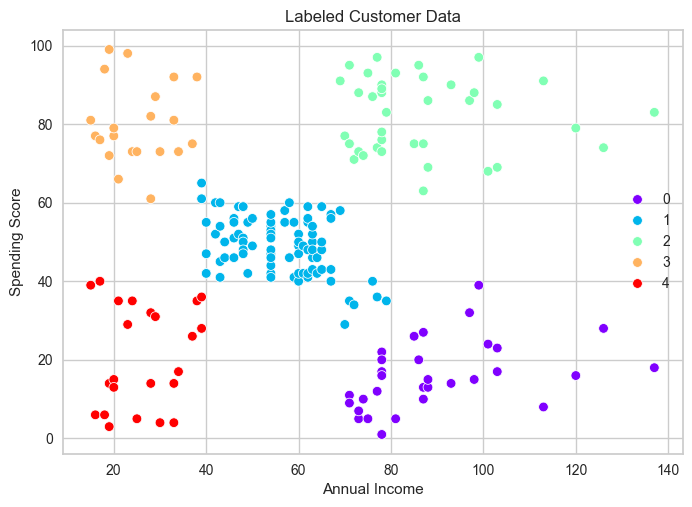

In [229]:
from sklearn.cluster import AgglomerativeClustering

# Use 'metric' instead of the deprecated 'affinity' argument
clustering_model = AgglomerativeClustering(
    n_clusters=5,
    metric='euclidean',
    linkage='ward'
)
clustering_model.fit(selected_data)

# Your cluster labels
labels = clustering_model.labels_

data_labels = clustering_model.labels_
sns.scatterplot(x='Annual Income',
                y='Spending Score',
                data=selected_data,
                hue=data_labels,
                palette="rainbow").set_title('Labeled Customer Data')

In [230]:
# Calculate silhouette score
silhouette_avg = silhouette_score(selected_data, clustering_model.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5529945955148897


DBScan

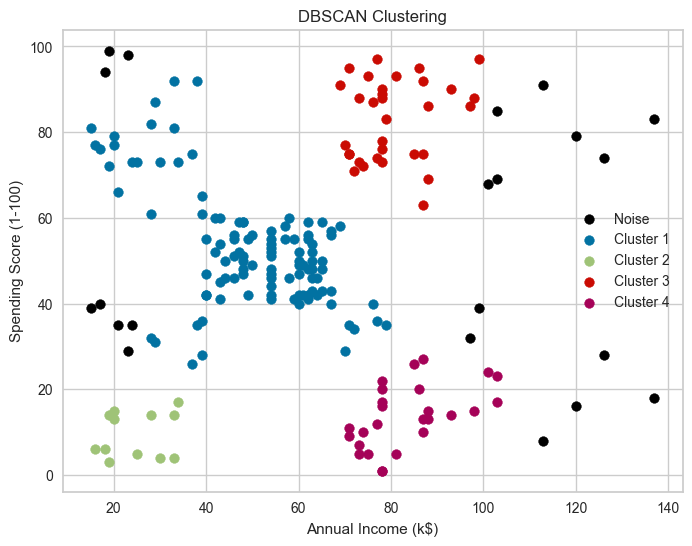

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# 1. Select features from the dataframe
X = df[['Annual Income', 'Spending Score']].values

# 2. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Perform DBSCAN clustering
# Adjust eps and min_samples if necessary for your data distribution
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

# 4. Inverse-transform the scaled data for plotting in original scale
X_original = scaler.inverse_transform(X_scaled)

# 5. Plot the DBSCAN clusters
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)

for cluster_label in unique_labels:
    # Create a mask for points in the current cluster
    mask = (labels == cluster_label)
    if cluster_label == -1:
        # DBSCAN labels noise as -1. Plot these in black.
        plt.scatter(X_original[mask, 0], X_original[mask, 1], c='black', label='Noise')
    else:
        plt.scatter(X_original[mask, 0], X_original[mask, 1], label=f'Cluster {cluster_label + 1}')

plt.title('DBSCAN Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()




- **Clustering based on Density:**  
  The plot shows the results of a Density‑Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm. Data points are grouped into clusters based on how densely they are packed, while points in low‑density regions are marked as noise.

- **Identified Clusters:**  
  Four distinct clusters have been identified, each rendered in a different color (blue, light green, red, magenta). These clusters represent regions where data points are closely packed together.

- **Noise Points:**  
  Black points scattered across the plot are labeled as “Noise” by DBSCAN. These outliers reside in sparsely populated areas and do not belong to any high‑density cluster.

- **Feature Space:**  
  - **X‑axis:** Annual Income (k\$)  
  - **Y‑axis:** Spending Score (1–100)  
  The clustering is based on the relationship between these two features.  
